In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import bibtexparser
import json
import openpyxl

In [2]:
dataset_folder = "data"
file = "unsupervised_collection.json"
# Cargar el archivo JSON exportado desde Zotero
with open(os.path.join(dataset_folder,file), 'r') as f:
    data = json.load(f)

# Extraer los datos relevantes
records = []
for item in data['items']:
    record = {
        'Citation Key': item.get('citationKey', 'N/A'),
        'Title': item.get('title', 'N/A'),
        'Author': ', '.join([creator['lastName'] for creator in item.get('creators', []) if 'lastName' in creator]),
        'Publication Year': item.get('date', 'N/A'),
        'Tags': item.get('tags')
        # Agrega más campos según sea necesario
    }
    records.append(record)

# Crear un DataFrame
df = pd.DataFrame(records)

In [3]:
df['Publication Year'] = df['Publication Year'].str.extract(r'(\d{4})')

In [4]:
df['Tags'] = df['Tags'].apply(lambda x: [tag['tag'] for tag in x] if isinstance(x, list) else [])

In [5]:
df.head()

,Citation Key,Title,Author,Publication Year,Tags
0,alnegheimishM2ADMultiSensorMultiSystem2025,M2AD: Multi-Sensor Multi-System Anomaly Detect...,"Alnegheimish, Chandrayan, He, Pradhan, Reimher...",2025,"[Deep Learning, notion, 1D input, Classified, ..."
1,arellano-espitiaDeepCompactClusteringBasedAnom...,Deep-Compact-Clustering Based Anomaly Detectio...,"Arellano-Espitia, Delgado-Prieto, Gonzalez-Abr...",2021,"[Anomaly detection, Deep Learning, Fault class..."
2,baidyaAnomalyDetectionTime2023,Anomaly Detection in Time Series Data Using Re...,"Baidya, Jeong",2023,"[Anomaly detection, Transformer, Autoencoder, ..."
3,chiBearingFaultDiagnosis2022,Bearing Fault Diagnosis for Time-Varying Syste...,"Chi, Yang, Shao, Zhang",2022,"[Anomaly detection, Deep Learning, Fault class..."
4,ellefsenOnlineFaultDetection2020,Online Fault Detection in Autonomous Ferries: ...,"Ellefsen, Han, Cheng, Holmeset, Aesoy, Zhang",2020,"[Anomaly detection, Deep Learning, SCADA data,..."


In [6]:
Method_type = ['Reconstruction','Forecasting-based','Representation','Hybrid']
Method_type_supervised = ['MC classification','AD output']
Architecture_type = ['Autoencoder', 'GAN', 'Variable Autoencoder','U-net', 'Normalizing Flow', 'Arch type: Custom Transformer', 'Arch type: Direct model', 'Arch type: SL', 'Autoencoder + Diffusion Model', 'Autoencoder + Transformer']
Base_model = ['MLP','CNN', 'LSTM', 'Transformer', 'Ensemble', 'Ensemble (CNN + Attention + LSTM)', 'GMM','IMMSC' ,'TCN','MOPA','CNN + RNN','CNN + DBN','CNN + Attention','CNN + SVM','CNN + RNN + Attention','DBN']
Component_type = ['Generic / Benchmark data', 'bearings', 'Aero engine', '3D printer', 'Chemical plant', 'Diesel engine','Engine','gearbox', 'Gearbox', 'Marine engine', 'Power plant', 'ECG data', 'IoT devices','Vehicle','Wind turbine','Power transformer','PV system','Chiller','Motor', 'Power lines', 'Industrial robot','Pump system']
Interpretability = ['Interpretability: Not addressed','Output residuals', 'Interpretability: Attention + residuals', 'Interpretability: Latent + Output residuals', 'Interpretability: Latent space', 'Interpretability: Output residuals', 'Interpretability: Feature maps', 'Interpretability: Feature importance']
Data_input = ['1D input', '2D input']
Data_channels = ['Univariate', 'Multivariate']
Fleet_data = ['Fleet data', 'Single entity']
Anomaly_score = ['Anomaly Score: Static', 'Anomaly Score: Dynamic']


In [7]:
def find_tag(tags, category_list):
    for tag in tags:
        if tag in category_list:
            return tag
    return None

In [8]:
# Crear un nuevo DataFrame con las categorías
new_data = []
missing_tags = []
for _, row in df.iterrows():
    tags = row['Tags']
    paper_data = {
        'Paper title': f"\\cite{{{row['Citation Key']}}}",
        'Publication Year': row['Publication Year'],
        'Method_type': find_tag(tags, Method_type),
        'Architecture_type': find_tag(tags, Architecture_type),
        'Base_model': find_tag(tags, Base_model),
        'Component_type': find_tag(tags, Component_type),
        'Interpretability': find_tag(tags, Interpretability),
        'Data_input': find_tag(tags, Data_input),
        'Data_channels': find_tag(tags, Data_channels),
        'Fleet_data': find_tag(tags, Fleet_data),
        'Anomaly_score': find_tag(tags, Anomaly_score),
    }
    
    # Verificar si falta alguna categoría
    if None in paper_data.values():
        missing_categories = [key for key, value in paper_data.items() if value is None]
        warnings.warn(f"El paper '{row['Title']}' no tiene tags para las categorías: {', '.join(missing_categories)}")
        missing_tags.append({'Paper title': row['Title'], 'Missing categories': missing_categories})
        
    new_data.append(paper_data)

# Crear el nuevo DataFrame
new_df = pd.DataFrame(new_data)

# Mostrar los artículos con categorías faltantes
if missing_tags:
    print("Artículos con categorías faltantes:")
    for item in missing_tags:
        print(f"- {item['Title']}: {', '.join(item['Missing categories'])}")


In [9]:
new_df['Paper title'][0]

'\\cite{alnegheimishM2ADMultiSensorMultiSystem2025}'

In [10]:
new_df['Interpretability'] = new_df['Interpretability'].replace({
    'Interpretability: Not addressed': r'\texttimes',
    'Interpretability: Attention + residuals': 'Attention + Res.',
    'Interpretability: Latent + Output residuals': 'Latent + Res.',
    'Interpretability: Latent space': 'Latent space',
    'Interpretability: Output residuals': 'Output Res.'
})

In [11]:
new_df['Base_model'] = new_df['Base_model'].replace({
    'Ensemble (CNN + Attention + LSTM)': 'CNN+Att.+LSTM',
    'IMMSC': 'Shallow learning',
    'MOPA': 'Shallow learning',
    'GMM': 'Shallow learning'
    
})

In [12]:
new_df['Architecture_type'] = new_df['Architecture_type'].replace({
    'Arch type: Custom Transformer': 'Custom Transformer',
    'Arch type: Direct model': 'Direct model',
    'Arch type: SL': 'Shallow learning',
    'Autoencoder + Diffusion Model': 'AE + Diffusion',
    'Autoencoder + Transformer': 'AE + Transformer'
})

In [13]:
new_df['Anomaly_score'] = new_df['Anomaly_score'].replace({
    'Anomaly Score: Static': 'Static',
    'Anomaly Score: Dynamic': 'Dynamic'
})

In [14]:
new_df['Component_type'] = new_df['Component_type'].replace({
    'Generic / Benchmark data': 'Benchmark data'
})

In [36]:
new_df = new_df.sort_values(by=['Method_type', 'Publication Year'], ascending=[True, False])

In [37]:
new_df.head()

,Paper title,Publication Year,Method_type,Architecture_type,Base_model,Component_type,Interpretability,Data_input,Data_channels,Fleet_data,Anomaly_score
0,\cite{alnegheimishM2ADMultiSensorMultiSystem2025},2025,Forecasting-based,Direct model,LSTM,Benchmark data,Output residuals,1D input,Multivariate,Fleet data,Dynamic
17,\cite{najafiAttentionAutoencoderHybrid2024},2024,Forecasting-based,Autoencoder,Transformer,Benchmark data,Output residuals,1D input,Multivariate,Single entity,Static
12,\cite{liuDeepAnomalyDetection2021},2021,Forecasting-based,Direct model,CNN,Benchmark data,\texttimes,1D input,Multivariate,Single entity,Static
15,\cite{minghuzhangDataDrivenAnomalyDetection2020},2020,Forecasting-based,Direct model,LSTM,IoT devices,\texttimes,1D input,Multivariate,Fleet data,Static
16,\cite{munirFuseADUnsupervisedAnomaly2019},2019,Forecasting-based,Autoencoder,CNN,Benchmark data,Output residuals,1D input,Multivariate,Single entity,Static


In [38]:
new_df.to_excel(os.path.join(dataset_folder, 'unsupervised_collection.xlsx'), index=False)

In [39]:
latex_df = new_df[['Paper title', 'Publication Year', 'Method_type', 'Base_model', 'Component_type', 'Fleet_data', 'Interpretability']]

In [40]:
# Exportar a LaTeX
latex_table = latex_df.to_latex(index=False)

# Opcional: guardar en un archivo .tex
with open('table.tex', 'w') as f:
    f.write(r'\begin{landscape}' + '\n')
    f.write(r'\begin{longtable}{lllll}' + '\n')  # Define las columnas de la tabla
    f.write(r'\caption{Summary table of papers for UAD in Time Series}\label{tab:unsupervised_table} \\ ' + '\n')
    f.write(r'\toprule' + '\n')
    f.write(r'Paper title & Publication Year & Method type & Base model & Component type & Fleet data & Interpretability \\ ' + '\n')
    f.write(r'\midrule' + '\n')
    f.write(r'\endfirsthead' + '\n')
    f.write(r'\toprule' + '\n')
    f.write(r'Paper title & Publication Year & Method type & Base model & Component type & Fleet data & Interpretability \\ ' + '\n')
    f.write(r'\midrule' + '\n')
    f.write(r'\endhead' + '\n')
    f.write(r'\bottomrule' + '\n')
    f.write(r'\endfoot' + '\n')
    f.write(latex_table + '\n')  # Aquí se inserta el contenido de la tabla
    f.write(r'\end{longtable}' + '\n')
    f.write(r'\end{landscape}' + '\n')

Plotting


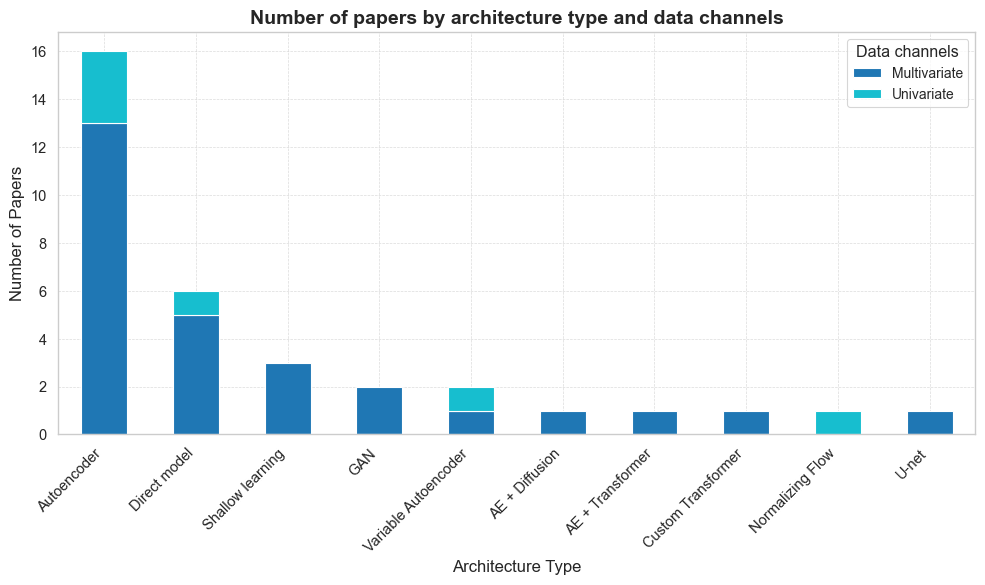

In [20]:

# Agrupar y contar el número de artículos por 'Architecture_type' y 'Data_channels'
grouped_df = new_df.groupby(['Architecture_type', 'Data_channels']).size().reset_index(name='Paper_count')

# Pivotar los datos para que cada 'Data_channels' sea una columna
pivot_df = grouped_df.pivot(index='Architecture_type', columns='Data_channels', values='Paper_count').fillna(0)

# Calcular el total de artículos por 'Architecture_type' y ordenar
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total', ascending=False).drop(columns=['Total'])  # Ordenar y eliminar columna auxiliar
# Configurar estilo de gráfico para publicaciones científicas
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")
# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))
bars = pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='tab10')

# Ajustar las etiquetas del eje X para que estén correctamente alineadas
ax.set_xticks(range(len(pivot_df.index)))  # Establecer las posiciones de las etiquetas
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')  # Alinear las etiquetas con las barras

# Personalizar el gráfico
ax.set_title('Number of papers by architecture type and data channels', fontsize=14, weight='bold')
ax.set_xlabel('Architecture Type', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.legend(title='Data channels', fontsize=10)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)  # Cuadrícula similar al gráfico compartido

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

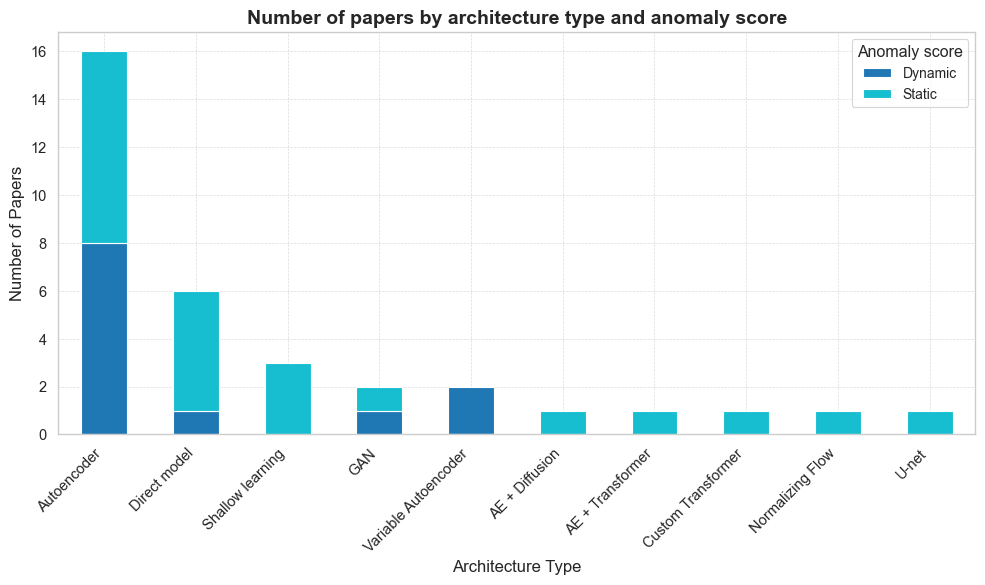

In [21]:
# Agrupar y contar el número de artículos por 'Architecture_type' y 'Anomaly_score'
grouped_df = new_df.groupby(['Architecture_type', 'Anomaly_score']).size().reset_index(name='Paper_count')

# Pivotar los datos para que cada 'Anomaly_score' sea una columna
pivot_df = grouped_df.pivot(index='Architecture_type', columns='Anomaly_score', values='Paper_count').fillna(0)

# Calcular el total de artículos por 'Architecture_type' y ordenar
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total', ascending=False).drop(columns=['Total'])  # Ordenar y eliminar columna auxiliar

# Configurar estilo de gráfico para publicaciones científicas
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))
bars = pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='tab10')

# Ajustar las etiquetas del eje X para que estén correctamente alineadas
ax.set_xticks(range(len(pivot_df.index)))  # Establecer las posiciones de las etiquetas
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')  # Alinear las etiquetas con las barras

# Personalizar el gráfico
ax.set_title('Number of papers by architecture type and anomaly score', fontsize=14, weight='bold')
ax.set_xlabel('Architecture Type', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.legend(title='Anomaly score', fontsize=10)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)  # Cuadrícula similar al gráfico compartido

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

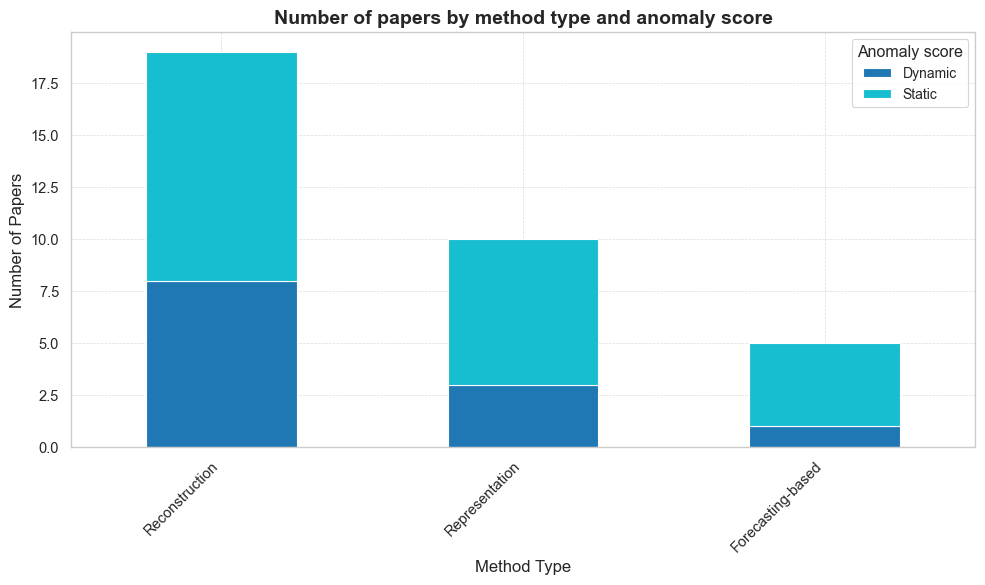

In [22]:
# Agrupar y contar el número de artículos por 'Method_type' y 'Anomaly_score'
grouped_df = new_df.groupby(['Method_type', 'Anomaly_score']).size().reset_index(name='Paper_count')

# Pivotar los datos para que cada 'Anomaly_score' sea una columna
pivot_df = grouped_df.pivot(index='Method_type', columns='Anomaly_score', values='Paper_count').fillna(0)

# Calcular el total de artículos por 'Method_type' y ordenar
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total', ascending=False).drop(columns=['Total'])  # Ordenar y eliminar columna auxiliar

# Configurar estilo de gráfico para publicaciones científicas
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))
bars = pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='tab10')

# Ajustar las etiquetas del eje X para que estén correctamente alineadas
ax.set_xticks(range(len(pivot_df.index)))  # Establecer las posiciones de las etiquetas
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')  # Alinear las etiquetas con las barras

# Personalizar el gráfico
ax.set_title('Number of papers by method type and anomaly score', fontsize=14, weight='bold')
ax.set_xlabel('Method Type', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.legend(title='Anomaly score', fontsize=10)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)  # Cuadrícula similar al gráfico compartido

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Supervised section


In [23]:
dataset_folder = "data"
file = "supervised_collection.json"
# Cargar el archivo JSON exportado desde Zotero
with open(os.path.join(dataset_folder,file), 'r') as f:
    data = json.load(f)

# Extraer los datos relevantes
records = []
for item in data['items']:
    record = {
        'Citation Key': item.get('citationKey', 'N/A'),
        'Title': item.get('title', 'N/A'),
        'Author': ', '.join([creator['lastName'] for creator in item.get('creators', []) if 'lastName' in creator]),
        'Publication Year': item.get('date', 'N/A'),
        'Tags': item.get('tags')
        # Agrega más campos según sea necesario
    }
    records.append(record)

# Crear un DataFrame
df_supervised = pd.DataFrame(records)

In [24]:
df_supervised['Publication Year'] = df_supervised['Publication Year'].str.extract(r'(\d{4})')

In [25]:
df_supervised['Tags'] = df_supervised['Tags'].apply(lambda x: [tag['tag'] for tag in x] if isinstance(x, list) else [])

In [26]:
df_supervised.head()

,Citation Key,Title,Author,Publication Year,Tags
0,amiriFaultDetectionDiagnosis2024,Fault Detection and Diagnosis of a Photovoltai...,"Amiri, Kichou, Oudira, Chouder, Silvestre",2024,"[Anomaly detection, CNN + RNN, Deep Learning, ..."
1,anDeepLearningBasedComposite2023,Deep Learning-Based Composite Fault Diagnosis,"An, Wu, Zhang, Ma, Sun, Tang, Liu",2023,"[1D input, Classified, CNN, Data handling tech..."
2,arellano-espitiaDeepLearningBasedMethodologyFa...,Deep-Learning-Based Methodology for Fault Diag...,"Arellano-Espitia, Delgado-Prieto, Martinez-Vio...",2020,"[1D input, Anomaly detection, Autoencoder, Cla..."
3,belagouneDeepLearningLSTM2021,Deep learning through LSTM classification and ...,"Belagoune, Bali, Bakdi, Baadji, Atif",2021,"[Anomaly detection, Deep Learning, Fault class..."
4,cheMultiscaleTimeFrequencySparse2023,Multiscale Time-Frequency Sparse Transformer B...,"Che, Lu, Bao, Zhang, Liu, Jiang",2023,"[2D input, Attention, Autoencoder, bearings, C..."


In [27]:
# Crear un nuevo DataFrame con las categorías
new_data = []
missing_tags = []
for _, row in df_supervised.iterrows():
    tags = row['Tags']
    paper_data = {
        'Paper title': f"\\cite{{{row['Citation Key']}}}",
        'Publication Year': row['Publication Year'],
        'Method_type': find_tag(tags, Method_type_supervised),
        'Base_model': find_tag(tags, Base_model),
        'Component_type': find_tag(tags, Component_type),
        'Interpretability': find_tag(tags, Interpretability),
        'Fleet_data': find_tag(tags, Fleet_data),
    }
    
    # Verificar si falta alguna categoría
    if None in paper_data.values():
        missing_categories = [key for key, value in paper_data.items() if value is None]
        warnings.warn(f"El paper '{row['Title']}' no tiene tags para las categorías: {', '.join(missing_categories)}")
        missing_tags.append({'Paper title': row['Title'], 'Missing categories': missing_categories})
        
    new_data.append(paper_data)

# Crear el nuevo DataFrame
new_df_supervised = pd.DataFrame(new_data)


In [28]:
new_df_supervised['Interpretability'] = new_df_supervised['Interpretability'].replace({
    'Interpretability: Not addressed': r'\texttimes',
    'Interpretability: Attention + residuals': 'Attention + Res.',
    'Interpretability: Latent + Output residuals': 'Latent + Res.',
    'Interpretability: Latent space': 'Latent space',
    'Interpretability: Feature maps': 'Feature maps',
    'Interpretability: Feature importance': 'Feature importance',
    'Interpretability: Output residuals': 'Output Res.'
})

In [29]:
new_df_supervised['Base_model'] = new_df_supervised['Base_model'].replace({
    'Ensemble (CNN + Attention + LSTM)': 'CNN+Att.+LSTM',
    'IMMSC': 'Shallow learning',
    'MOPA': 'Shallow learning',
    'GMM': 'Shallow learning'
    
})

In [30]:
new_df_supervised['Component_type'] = new_df_supervised['Component_type'].replace({
    'Generic / Benchmark data': 'Benchmark data'
})

In [31]:
new_df_supervised = new_df_supervised.sort_values(by=['Method_type','Publication Year'], ascending=False)

In [32]:
new_df_supervised.head()

,Paper title,Publication Year,Method_type,Base_model,Component_type,Interpretability,Fleet_data
9,\cite{farahaniTimeseriesClassificationSmart2025},2025,MC classification,CNN,bearings,\texttimes,Single entity
19,\cite{liFaultDiagnosisHeterogeneous2025},2025,MC classification,CNN + RNN + Attention,Power plant,Feature maps,Single entity
38,\cite{zhaoDenoisingDiffusionProbabilistic2025},2025,MC classification,CNN,bearings,\texttimes,Single entity
40,\cite{zhuDesignModelFusion2025},2025,MC classification,CNN + RNN,Chemical plant,Latent space,Single entity
0,\cite{amiriFaultDetectionDiagnosis2024},2024,MC classification,CNN + RNN,PV system,Output residuals,Single entity


In [33]:
latex_df_supervised = new_df_supervised[['Paper title', 'Publication Year', 'Method_type', 'Base_model', 'Component_type', 'Fleet_data', 'Interpretability']]

In [34]:
# Exportar a LaTeX
latex_table = latex_df_supervised.to_latex(index=False)

# Opcional: guardar en un archivo .tex
with open('table_supervised.tex', 'w') as f:
    f.write(r'\begin{landscape}' + '\n')
    f.write(r'\begin{longtable}{lllll}' + '\n')  # Define las columnas de la tabla
    f.write(r'\caption{Summary table of papers for IFD}\label{tab:unsupervised_table} \\ ' + '\n')
    f.write(r'\toprule' + '\n')
    f.write(r'Paper title & Publication Year & Method type & Base model & Component type & Fleet data & Interpretability \\ ' + '\n')
    f.write(r'\midrule' + '\n')
    f.write(r'\endfirsthead' + '\n')
    f.write(r'\toprule' + '\n')
    f.write(r'Paper title & Publication Year & Method type & Base model & Component type & Fleet data & Interpretability \\ ' + '\n')
    f.write(r'\midrule' + '\n')
    f.write(r'\endhead' + '\n')
    f.write(r'\bottomrule' + '\n')
    f.write(r'\endfoot' + '\n')
    f.write(latex_table + '\n')  # Aquí se inserta el contenido de la tabla
    f.write(r'\end{longtable}' + '\n')
    f.write(r'\end{landscape}' + '\n')

Plotting - Supervised

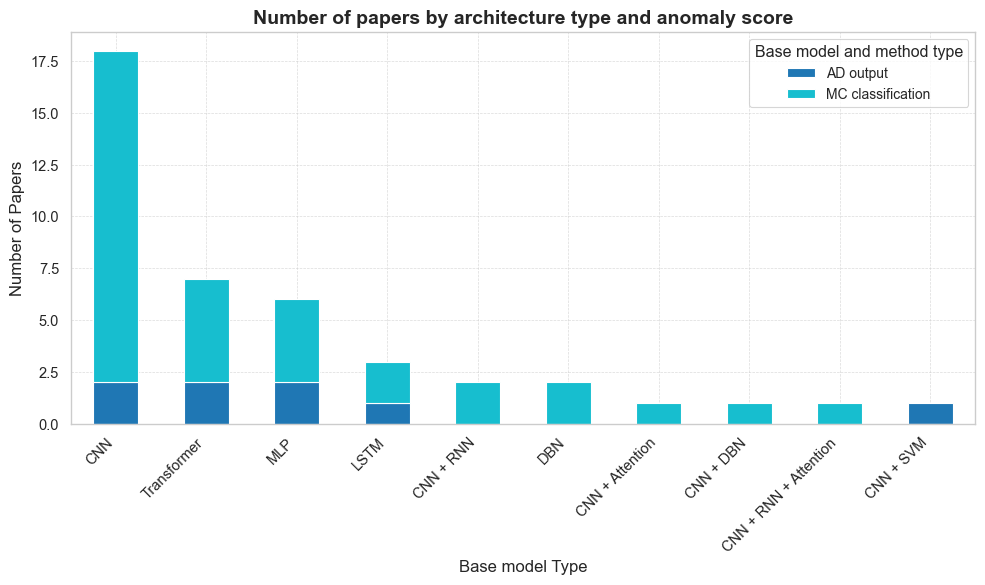

In [35]:
# Agrupar y contar el número de artículos por 'Architecture_type' y 'Anomaly_score'
grouped_df = new_df_supervised.groupby(['Base_model', 'Method_type']).size().reset_index(name='Paper_count')

# Pivotar los datos para que cada 'Anomaly_score' sea una columna
pivot_df = grouped_df.pivot(index='Base_model', columns='Method_type', values='Paper_count').fillna(0)

# Calcular el total de artículos por 'Architecture_type' y ordenar
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total', ascending=False).drop(columns=['Total'])  # Ordenar y eliminar columna auxiliar

# Configurar estilo de gráfico para publicaciones científicas
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

# Crear el gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))
bars = pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='tab10')

# Ajustar las etiquetas del eje X para que estén correctamente alineadas
ax.set_xticks(range(len(pivot_df.index)))  # Establecer las posiciones de las etiquetas
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')  # Alinear las etiquetas con las barras

# Personalizar el gráfico
ax.set_title('Number of papers by architecture type and anomaly score', fontsize=14, weight='bold')
ax.set_xlabel('Base model Type', fontsize=12)
ax.set_ylabel('Number of Papers', fontsize=12)
ax.legend(title='Base model and method type', fontsize=10)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)  # Cuadrícula similar al gráfico compartido

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()